# Aiida

https://github.com/BAMresearch/NFDI4IngScientificWorkflowRequirements

## Define workflow with aiida

In [1]:
from python_workflow_definition.aiida import write_workflow_json

from aiida_workgraph import WorkGraph, task
from aiida import orm, load_profile
load_profile()

Profile<uuid='9da6a68ed2b14ffb920b92aa0a616339' name='pwd'>

In [2]:
from nfdi_ing_workflow import (
    generate_mesh,
    convert_to_xdmf as _convert_to_xdmf,
    poisson as _poisson,
    plot_over_line,
    substitute_macros,
    compile_paper,
)

In [3]:
convert_to_xdmf = task(outputs=["xdmf_file", "h5_file"])(_convert_to_xdmf)
poisson = task(outputs=["numdofs", "pvd_file", "vtu_file"])(_poisson)

In [4]:
domain_size = orm.Float(2.0)

In [5]:
wg = WorkGraph("wg-nfdi")

In [6]:
gmsh_output_file = wg.add_task(
    generate_mesh,
    name="generate_mesh",
    domain_size=domain_size,
)

In [7]:
meshio_output_dict = wg.add_task(
    convert_to_xdmf,
    name="convert_to_xdmf",
    gmsh_output_file=gmsh_output_file.outputs.result,
)

In [8]:
poisson_dict = wg.add_task(
    poisson,
    name="poisson",
    meshio_output_xdmf=meshio_output_dict.outputs.xdmf_file, 
    meshio_output_h5=meshio_output_dict.outputs.h5_file,
)

In [9]:
pvbatch_output_file = wg.add_task(
    plot_over_line,
    name="plot_over_line",
    poisson_output_pvd_file=poisson_dict.outputs.pvd_file, 
    poisson_output_vtu_file=poisson_dict.outputs.vtu_file,
)

In [10]:
macros_tex_file = wg.add_task(
    substitute_macros,
    name="substitute_macros",
    pvbatch_output_file=pvbatch_output_file.outputs.result, 
    ndofs=poisson_dict.outputs.numdofs, 
    domain_size=domain_size,
)

In [11]:
paper_output = wg.add_task(
    compile_paper,
    name="compile_paper",
    macros_tex=macros_tex_file.outputs.result, 
    plot_file=pvbatch_output_file.outputs.result,
)

In [12]:
wg

NodeGraphWidget(settings={'minimap': True}, style={'width': '90%', 'height': '600px'}, value={'name': 'wg-nfdi…

In [13]:
workflow_json_filename = "aiida_nfdi.json"

In [14]:
write_workflow_json(wg=wg, file_name=workflow_json_filename)

{'nodes': [{'id': 0, 'function': 'nfdi_ing_workflow.generate_mesh'},
  {'id': 1, 'function': 'nfdi_ing_workflow.convert_to_xdmf'},
  {'id': 2, 'function': 'nfdi_ing_workflow.poisson'},
  {'id': 3, 'function': 'nfdi_ing_workflow.plot_over_line'},
  {'id': 4, 'function': 'nfdi_ing_workflow.substitute_macros'},
  {'id': 5, 'function': 'nfdi_ing_workflow.compile_paper'},
  {'id': 6, 'value': 2.0}],
 'edges': [{'target': 1,
   'targetPort': 'gmsh_output_file',
   'source': 0,
   'sourcePort': None},
  {'target': 2,
   'targetPort': 'meshio_output_xdmf',
   'source': 1,
   'sourcePort': 'xdmf_file'},
  {'target': 2,
   'targetPort': 'meshio_output_h5',
   'source': 1,
   'sourcePort': 'h5_file'},
  {'target': 3,
   'targetPort': 'poisson_output_pvd_file',
   'source': 2,
   'sourcePort': 'pvd_file'},
  {'target': 3,
   'targetPort': 'poisson_output_vtu_file',
   'source': 2,
   'sourcePort': 'vtu_file'},
  {'target': 4,
   'targetPort': 'pvbatch_output_file',
   'source': 3,
   'sourcePort':

In [15]:
!cat {workflow_json_filename}

{
  "nodes": [
    {
      "id": 0,
      "function": "nfdi_ing_workflow.generate_mesh"
    },
    {
      "id": 1,
      "function": "nfdi_ing_workflow.convert_to_xdmf"
    },
    {
      "id": 2,
      "function": "nfdi_ing_workflow.poisson"
    },
    {
      "id": 3,
      "function": "nfdi_ing_workflow.plot_over_line"
    },
    {
      "id": 4,
      "function": "nfdi_ing_workflow.substitute_macros"
    },
    {
      "id": 5,
      "function": "nfdi_ing_workflow.compile_paper"
    },
    {
      "id": 6,
      "value": 2.0
    }
  ],
  "edges": [
    {
      "target": 1,
      "targetPort": "gmsh_output_file",
      "source": 0,
      "sourcePort": null
    },
    {
      "target": 2,
      "targetPort": "meshio_output_xdmf",
      "source": 1,
      "sourcePort": "xdmf_file"
    },
    {
      "target": 2,
      "targetPort": "meshio_output_h5",
      "source": 1,
      "sourcePort": "h5_file"
    },
    {
      "target": 3,
      "targetPort": "poisson_output_pvd_file",
      

## Load Workflow with jobflow

In [16]:
from python_workflow_definition.jobflow import load_workflow_json

/srv/conda/envs/notebook/lib/python3.12/site-packages/paramiko/pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "cipher": algorithms.TripleDES,
/srv/conda/envs/notebook/lib/python3.12/site-packages/paramiko/transport.py:253: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "class": algorithms.TripleDES,


In [17]:
from jobflow.managers.local import run_locally

In [18]:
flow = load_workflow_json(file_name=workflow_json_filename)

In [19]:
result = run_locally(flow)
result

2025-04-12 11:30:36,604 INFO Started executing jobs locally
2025-04-12 11:30:37,162 INFO Starting job - generate_mesh (5709b90c-3e6a-43bb-9deb-b11fc240bfe0)
2025-04-12 11:30:42,424 INFO Finished job - generate_mesh (5709b90c-3e6a-43bb-9deb-b11fc240bfe0)
2025-04-12 11:30:42,428 INFO Starting job - convert_to_xdmf (b7865f27-520b-4a07-9d84-4e7973137eaa)
2025-04-12 11:30:45,227 INFO Finished job - convert_to_xdmf (b7865f27-520b-4a07-9d84-4e7973137eaa)
2025-04-12 11:30:45,228 INFO Starting job - poisson (01ddf0e3-cba6-4781-bc8c-ea7223612cc2)
2025-04-12 11:31:04,150 INFO Finished job - poisson (01ddf0e3-cba6-4781-bc8c-ea7223612cc2)
2025-04-12 11:31:04,152 INFO Starting job - plot_over_line (47a7c359-2e25-4321-8f28-63cd70cd0e77)
2025-04-12 11:31:08,074 INFO Finished job - plot_over_line (47a7c359-2e25-4321-8f28-63cd70cd0e77)
2025-04-12 11:31:08,076 INFO Starting job - substitute_macros (6c382cd4-9bea-493a-91e1-6bc556e6e91e)
2025-04-12 11:31:09,846 INFO Finished job - substitute_macros (6c382c

{'5709b90c-3e6a-43bb-9deb-b11fc240bfe0': {1: Response(output='/home/jovyan/preprocessing/square.msh', detour=None, addition=None, replace=None, stored_data=None, stop_children=False, stop_jobflow=False, job_dir=PosixPath('/home/jovyan'))},
 'b7865f27-520b-4a07-9d84-4e7973137eaa': {1: Response(output={'xdmf_file': '/home/jovyan/preprocessing/square.xdmf', 'h5_file': '/home/jovyan/preprocessing/square.h5'}, detour=None, addition=None, replace=None, stored_data=None, stop_children=False, stop_jobflow=False, job_dir=PosixPath('/home/jovyan'))},
 '01ddf0e3-cba6-4781-bc8c-ea7223612cc2': {1: Response(output={'numdofs': 357, 'pvd_file': '/home/jovyan/processing/poisson.pvd', 'vtu_file': '/home/jovyan/processing/poisson000000.vtu'}, detour=None, addition=None, replace=None, stored_data=None, stop_children=False, stop_jobflow=False, job_dir=PosixPath('/home/jovyan'))},
 '47a7c359-2e25-4321-8f28-63cd70cd0e77': {1: Response(output='/home/jovyan/postprocessing/plotoverline.csv', detour=None, additi

## Load Workflow with pyiron_base

In [21]:
from python_workflow_definition.pyiron_base import load_workflow_json

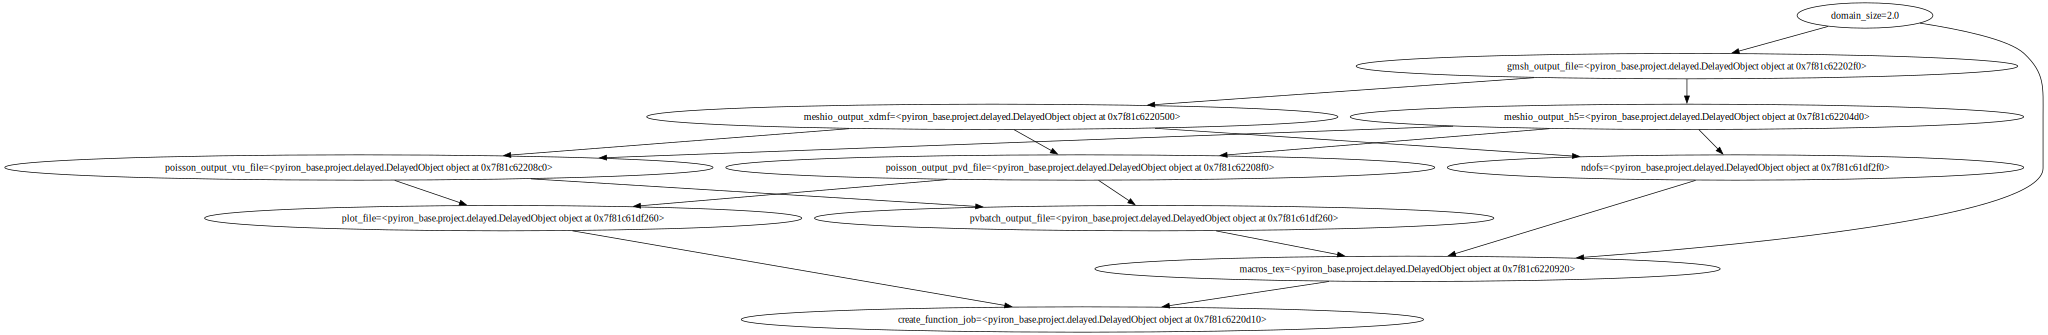

In [23]:
delayed_object_lst = load_workflow_json(file_name=workflow_json_filename)
delayed_object_lst[-1].draw()

In [24]:
delayed_object_lst[-1].pull()

The job generate_mesh_0b48cf5155cd6802c17d20bb58104132 was saved and received the ID: 1
The job convert_to_xdmf_29ad6ec6927268429dc9aef8166fde43 was saved and received the ID: 2
The job poisson_a0224b23ceb2119d105a5d98ef37f93e was saved and received the ID: 3
The job plot_over_line_82b37a42e0747f11d9a7f6318f63ac6b was saved and received the ID: 4
The job substitute_macros_874fc185ecec04b4cb9537c58b7efb7b was saved and received the ID: 5
The job compile_paper_3cee534ffe692833d37faf1fd2170cb6 was saved and received the ID: 6


'/home/jovyan/postprocessing/paper.pdf'